In this notebook, we apply better (MI) attacks to the `digress` synthetic datasets.

In [1]:
import pickle
import numpy as np
import networkx as nx
import os
import pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Load the training datasets (numbered 11 to 20).

In [3]:
training_graphs = {}
for i in range(11, 20):
    with open(f'deezer_ego_nets/split/deezer_edge_lists_100_nodes_set_{i}.pkl', 'rb') as ff:
        training_graphs[i-10] = [nx.from_edgelist(l) for l in pickle.load(ff)]
#     print(len(training_graphs[i-10]))

Load a (disjoint?) test dataset.

In [4]:
with open('deezer_subset_test.pkl', 'rb') as ff:
    test = pickle.load(ff)

In [5]:
testing_graphs = [nx.from_edgelist(l) for l in test]

Load synthetic datasets.

In [6]:
synthetic_graphs = {}

In [7]:
for i in range(1, 10):
    filename = f'digress/set{i}_generated_adjs.npz'
    print(f'Loading {filename}...')
    # Code from Praveen.
    loaded_data = np.load(filename)
    loaded_adjacency_matrices = [loaded_data[key] for key in loaded_data]
    loaded_networkx_graphs = [nx.from_numpy_array(adj_matrix) for adj_matrix in loaded_adjacency_matrices]
    synthetic_graphs[i] = loaded_networkx_graphs
    print(f'Loaded {len(loaded_networkx_graphs)} graphs.')

Loading digress/set1_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set2_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set3_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set4_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set5_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set6_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set7_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set8_generated_adjs.npz...
Loaded 512 graphs.
Loading digress/set9_generated_adjs.npz...
Loaded 512 graphs.


Kernel stuff.

In [8]:
import grakel
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [9]:
from grakel import WeisfeilerLehman, VertexHistogram

Compute the kernel as features for training and testing.

In [10]:
x = []
y = []

for i in range(1, 10):
    # Fit the kernel on the synthetic dataset.
    kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
    kernel.fit(_grak(synthetic_graphs[i]))
    # Training set.
    x.append(kernel.transform(_grak(training_graphs[i])))
    y.append([1] * len(training_graphs[i]))
    # As testing set, use the next (disjoint) training set. This is arbitrary.
    next_i = i+1 if i < 9 else 1
    x.append(kernel.transform(_grak(training_graphs[next_i])))
    y.append([0] * len(training_graphs[next_i]))

In [11]:
x = np.concatenate(x)
y = np.concatenate(y)

Define the train/test split however you wish.

In [12]:
# # Unrealistic, but simple model: random sampling of all models.
train_indices = np.random.random(y.shape) < 0.8

So here is the issue: the previous one works pretty well, but _not_ the second (more realistic) setup, where we attack new synthetic datasets.

In [13]:
# Better idea: have some datasets be test.
# train_indices = np.arange(y.shape[0]) < int(0.8 * y.shape[0])

In [14]:
test_indices = ~train_indices

In [15]:
X_train = x[train_indices,:]
y_train = y[train_indices]
X_test = x[test_indices,:]
y_test = y[test_indices]

Privacy evaluation: utilities.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [17]:
def evaluate_privacy(model, extract_features):
    ft_train = extract_features(X_train)
    ft_test = extract_features(X_test)
    model.fit(ft_train, y_train)
    train_scores = model.predict_proba(ft_train)[:,1]
    test_scores = model.predict_proba(ft_test)[:,1]
    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    fpr, tpr, _ = roc_curve(y_train, train_scores)
    plt.plot(fpr, tpr, 'g--', label='Training')
    print('TRAIN', roc_auc_score(y_train, train_scores))
    fpr, tpr, _ = roc_curve(y_test, test_scores)
    plt.plot(fpr, tpr, 'b', label='Testing')
    print('TEST ', roc_auc_score(y_test, test_scores))
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])

### Naive: just use the kernel as features

TRAIN 0.9968152196762666
TEST  0.45556990636099454


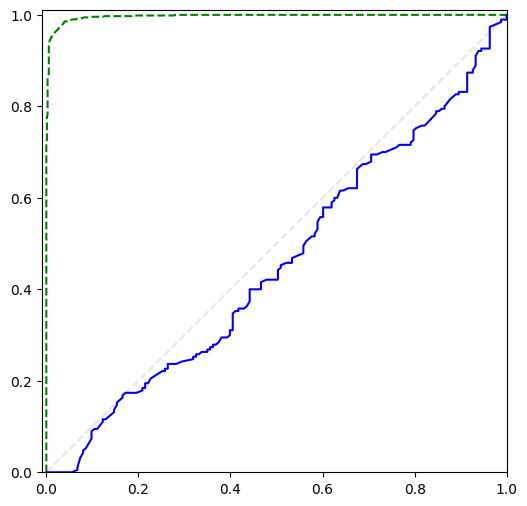

In [18]:
evaluate_privacy(RandomForestClassifier(), lambda x:x)

TRAIN 0.5920375714258415
TEST  0.5001775912173071


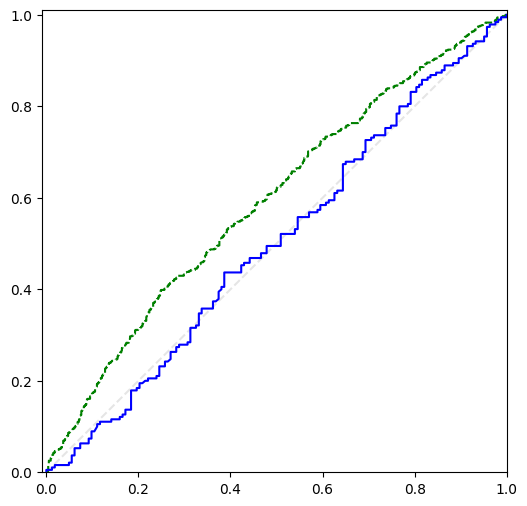

In [19]:
evaluate_privacy(LogisticRegression(), lambda x:x)

This does not work at all.

### A bit less naive: sorting kernel values

TRAIN 0.9951334874921169
TEST  0.5150306748466258


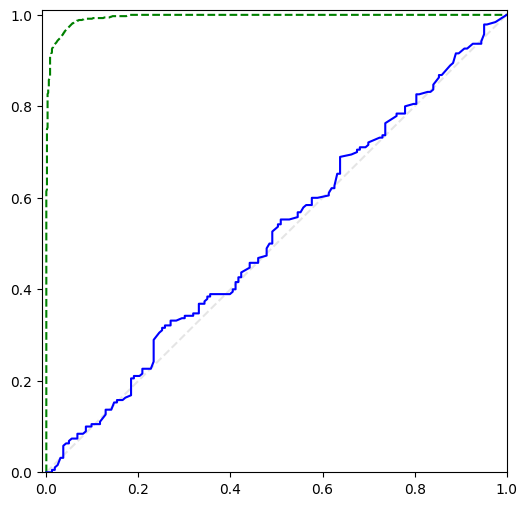

In [20]:
evaluate_privacy(RandomForestClassifier(), lambda x: np.sort(x, axis=1))

This works so well!

TRAIN 0.5844525770634662
TEST  0.511979334840168


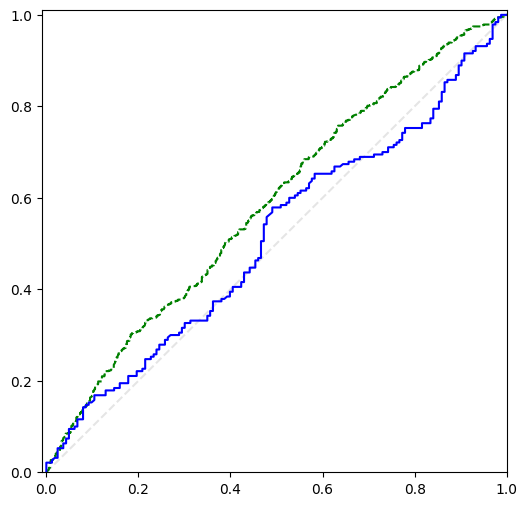

In [21]:
evaluate_privacy(LogisticRegression(), lambda x: np.sort(x, axis=1))

### top-k values

TRAIN 0.885032583561068
TEST  0.5332095576364224


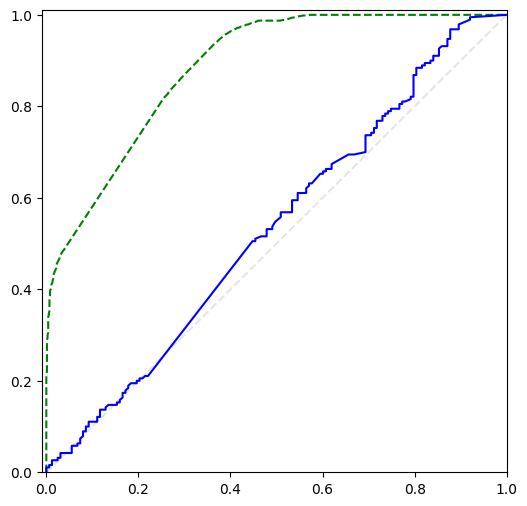

In [22]:
k = 10
evaluate_privacy(RandomForestClassifier(), lambda x: np.sort(x, axis=1)[:,-k:])

Good, similar to sorted values.

### Percentile values

TRAIN 0.9568874577178129
TEST  0.5168873103002906


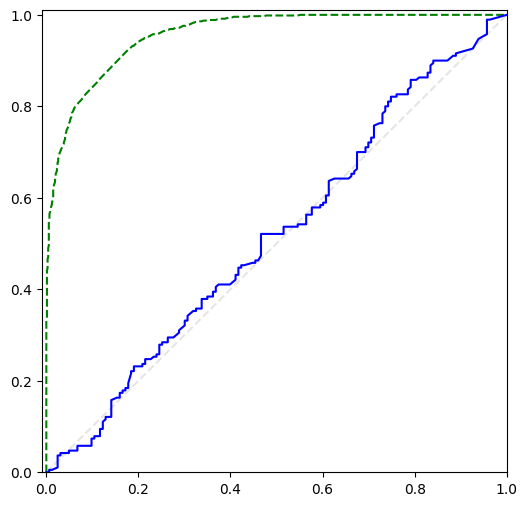

In [23]:
percentiles = np.linspace(1, 99, 18)

evaluate_privacy(
    RandomForestClassifier(),
    lambda x: np.concatenate((
        np.min(x, axis=1).reshape(-1, 1),
        np.percentile(x, percentiles, axis=1).T,
        np.max(x, axis=1).reshape(-1, 1)
    ), axis=1)
)

This seems to work well too!

### alpha-norms

TRAIN 0.9952328625757257
TEST  0.48919922505650626


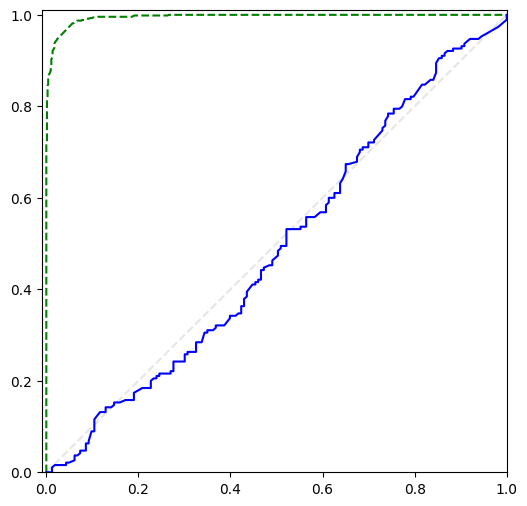

In [24]:
evaluate_privacy(
    RandomForestClassifier(),
    lambda x: np.concatenate([
        np.linalg.norm(x, ord=alpha, axis=1).reshape(-1, 1) for alpha in [2, 3, 4, 5, 6, 7, 8, 9, 10]
    ], axis=1)
)